## Прогнозирование стоимости криптовалюты Etherium

##### Источник данных: https://investfunds.ru/


In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

import requests
from urllib.parse import urlencode

from datetime import date
from datetime import datetime

import holidays

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import add_changepoints_to_plot


In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/i/QV5I0VBeBb3JpA'  # Сюда вписываете вашу ссылку

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

In [3]:
# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
df = pd.read_excel(download_url, header=0)

In [4]:
# Приводим df к нужному для Prophet вида: удаляем лишние столбцы, переименовываем колонки
df = df.drop(['Цена, BTC', 'Объём торгов по всем биржам, USD', 'Капитализация, USD'], axis=1) \
       .rename(columns={'Дата': 'ds', 'Цена, USD': 'y'})

In [5]:
df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [6]:
# Проверяем на отсутствующие данные
df.isnull().sum()

ds    0
y     0
dtype: int64

In [7]:
df.shape

(731, 2)

In [8]:
df = df.sort_values(by='ds')

In [9]:
df.head()

,ds,y
730,2020-03-01,218.97
729,2020-03-02,230.57
728,2020-03-03,224.48
727,2020-03-04,224.52
726,2020-03-05,229.27


C:\Users\Nata\AppData\Local\Temp\ipykernel_9076\4242873288.py:2: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  plt.plot('ds', 'y', data=df)


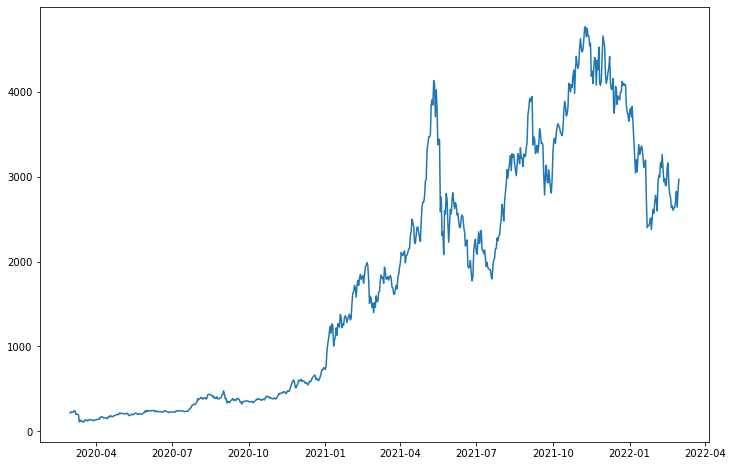

In [10]:
plt.figure(figsize=(12,8))
plt.plot('ds', 'y', data=df)
plt.show()

In [11]:
# Создаем словарь с праздниками для учета моделью
holidays_dict = holidays.RU(years=(2020, 2021, 2022))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.head()

,ds,holiday
0,2020-01-01,Новый год
1,2020-01-02,Новый год
2,2020-01-03,Новый год
3,2020-01-04,Новый год
4,2020-01-05,Новый год


На стоимость Ethereum оказывали влияние выходы апгрейдов в 2020 - 2021 году   В качестве примера, возьмем некоторые из этих событий:

In [12]:
# event_1 - Staking deposit contract deployed
# event_2 - Beacon Chain genesis
# event_3 - The Berlin upgrade
# event_4 - The London upgrade
# event_5 - The Altair upgrade
# event_6 - The Arrow Glacier network upgrade

key_dates = pd.DataFrame({'ds': pd.Series(['2020-10-14', '2020-12-01', '2021-04-15', '2021-08-05', '2021-10-27', '2021-12-09'], dtype='datetime64[ns]'), 
              'holiday': ['Staking deposit contract deployed', 'Beacon Chain genesis', 'The Berlin upgrade', 'The London upgrade', 'The Altair upgrade', 'The Arrow Glacier network upgrade']})

In [13]:
key_dates

,ds,holiday
0,2020-10-14,Staking deposit contract deployed
1,2020-12-01,Beacon Chain genesis
2,2021-04-15,The Berlin upgrade
3,2021-08-05,The London upgrade
4,2021-10-27,The Altair upgrade
5,2021-12-09,The Arrow Glacier network upgrade


Так как данные ключевые события были ожидаемы, имело бы смысл моделировать события c 'предысторией', т.е. как события, чей эффект начал проявлять себя за пару недель до события.

In [14]:
lower_window = [-14, -14, -14, -14, -14, -14]

In [15]:
upper_window = [0, 0, 0, 0, 0, 0]

In [16]:
key_dates['lower_window'] = lower_window

In [17]:
key_dates['upper_window'] = upper_window

In [18]:
key_dates.dtypes

ds              datetime64[ns]
holiday                 object
lower_window             int64
upper_window             int64
dtype: object

In [19]:
# объединяем праздники и ключевые даты в один df
df_holidays_full = df_holidays.append(key_dates).reset_index().drop('index', axis=1)

C:\Users\Nata\AppData\Local\Temp\ipykernel_9076\3906203297.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_holidays_full = df_holidays.append(key_dates).reset_index().drop('index', axis=1)


In [20]:
df_holidays_full.tail(10)

,ds,holiday,lower_window,upper_window
41,2022-05-09,День Победы,NaN,NaN
42,2022-06-12,День России,NaN,NaN
43,2022-11-04,День народного единства,NaN,NaN
44,2022-12-31,Новый год,NaN,NaN
45,2020-10-14,Staking deposit contract deployed,-14.0,0.0
46,2020-12-01,Beacon Chain genesis,-14.0,0.0
47,2021-04-15,The Berlin upgrade,-14.0,0.0
48,2021-08-05,The London upgrade,-14.0,0.0
49,2021-10-27,The Altair upgrade,-14.0,0.0
50,2021-12-09,The Arrow Glacier network upgrade,-14.0,0.0


In [21]:
# Кол-во дней, которые надо отрезать и предсказать
predictions = 30

In [22]:
# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = df[:-predictions]

### Настроим гиперпараметры

In [23]:
# Попробуем разные сочетания гиперпараметров

param_grid = {  
    'changepoint_prior_scale': [0.25, 0.05, 0.1], ## по умолчанию 0.05, попробуем увеличить и уменьшить в два раза
    'seasonality_prior_scale': [5.0, 10.0, 20.0], ## по умолчанию 10.0, попробуем увеличить и уменьшить в два раза
    'holidays_prior_scale': [5.0, 10.0, 20.0], ## по умолчанию 10.0, попробуем увеличить и уменьшить в два раза
}

# Создаем все комбинации параметров
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []  # Сюда будем складывать метрику MAPE

# Проводим кроссвалидацию со всеми комбинациями параметров
for params in all_params:
    m = Prophet(**params, holidays=df_holidays_full, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, initial='180 days', period='30 days', horizon = '60 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1) ## тут окно для подсчета метрики 1, чтобы метрика считалась по всему горизонту
    mapes.append(df_p['mape'].values[0])

# Смотрим на результаты с разными параметрами
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
print(tuning_results)

C:\Users\Nata\anaconda3\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 17 forecasts with cutoffs between 2020-09-07 00:00:00 and 2021-12-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000015D9A42FE50>
C:\Users\Nata\anaconda3\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 17 forecasts with cutoffs between 2020-09-07 00:00:00 and 2021-12-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000015D9655B7C0>
C:\Users\Nata\anaconda3\envs\time_

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000015D9479B3A0>
C:\Users\Nata\anaconda3\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 17 forecasts with cutoffs between 2020-09-07 00:00:00 and 2021-12-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000015D9655B730>
C:\Users\Nata\anaconda3\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Making 17 forecasts with cutoffs between 2020-09-07 00:00:00 and 2021-12-31 00:00:00
INFO:fbprophet:Applying in paralle

    changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                      0.25                      5.0                   5.0   
1                      0.25                      5.0                  10.0   
2                      0.25                      5.0                  20.0   
3                      0.25                     10.0                   5.0   
4                      0.25                     10.0                  10.0   
5                      0.25                     10.0                  20.0   
6                      0.25                     20.0                   5.0   
7                      0.25                     20.0                  10.0   
8                      0.25                     20.0                  20.0   
9                      0.05                      5.0                   5.0   
10                     0.05                      5.0                  10.0   
11                     0.05                      5.0            

In [24]:
# Отображаем лучшие параметры
best_params = all_params[np.argmin(mapes)]
print(best_params)

{'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0}


In [25]:
# Настраиваем prophet: учитываем сезонности, праздники и рассчитанные параметры

m_1 = Prophet(holidays=df_holidays_full, daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True,
              changepoint_prior_scale=0.05, seasonality_prior_scale=5.0, holidays_prior_scale=5.0)
# добавим месячную сезонность
m_1.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m_1.fit(train_df)

C:\Users\Nata\anaconda3\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


In [26]:
# настроиваем кроссвалидацию
# period = предсказываемый период
# horizon = period * 2
# initial = horizon * 3
# при этом, периоды нужно расставить так, чтобы в ваш временной ряд влезло несколько прогнозов
df_cv = cross_validation(m_1, initial='180 days', period='30 days', horizon='60 days', parallel="processes")

INFO:fbprophet:Making 16 forecasts with cutoffs between 2020-09-07 00:00:00 and 2021-12-01 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000015D964F4520>


In [27]:
# считаем метрики модели на разных горизонтах прогнозирования
# rolling_window - размер 'скользящего окна', в пределах которого происходит усреднение каждой метрики 
# по умолчанию принимает значение 0.1, т.е. 10% от длины прогнозного горизонта
df_p = performance_metrics(df_cv, rolling_window = 0.1)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,6 days,2.259148e+05,475.304959,352.597868,0.156874,0.128519,0.187500
1,7 days,2.570011e+05,506.952736,385.382332,0.181103,0.141713,0.156250
2,8 days,2.860110e+05,534.800002,417.335891,0.207077,0.155188,0.114583
3,9 days,3.035032e+05,550.911225,439.629113,0.230980,0.165951,0.093750
4,10 days,3.253972e+05,570.435995,462.827757,0.255808,0.176445,0.083333
5,11 days,3.511805e+05,592.604812,486.482986,0.279194,0.193100,0.072917
6,12 days,3.825391e+05,618.497427,510.957054,0.302674,0.218613,0.072917
7,13 days,4.090665e+05,639.583089,533.044776,0.328167,0.226380,0.052083
8,14 days,4.294084e+05,655.292574,552.590060,0.351189,0.227865,0.031250
9,15 days,4.448109e+05,666.941478,564.006257,0.372208,0.226380,0.041667


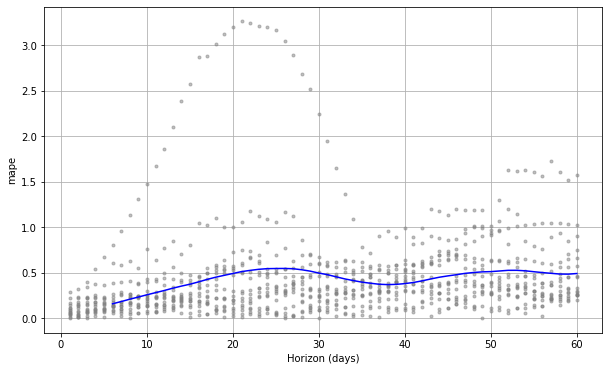

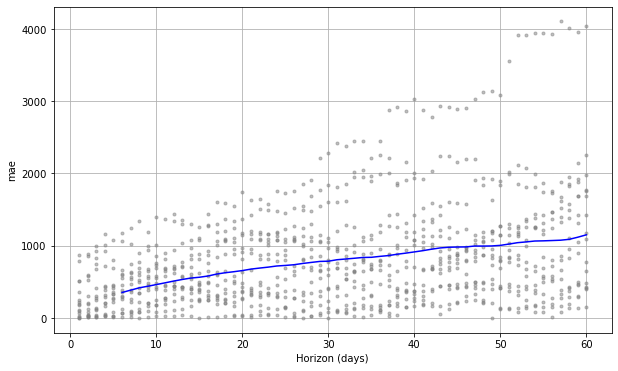

In [28]:
# визуализируем метрики
fig1 = plot_cross_validation_metric(df_cv, metric='mape')
fig2 = plot_cross_validation_metric(df_cv, metric='mae')

In [29]:
# Предсказываем 30 дней
future = m_1.make_future_dataframe(periods=predictions)
forecast = m_1.predict(future)

C:\Users\Nata\anaconda3\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Nata\anaconda3\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


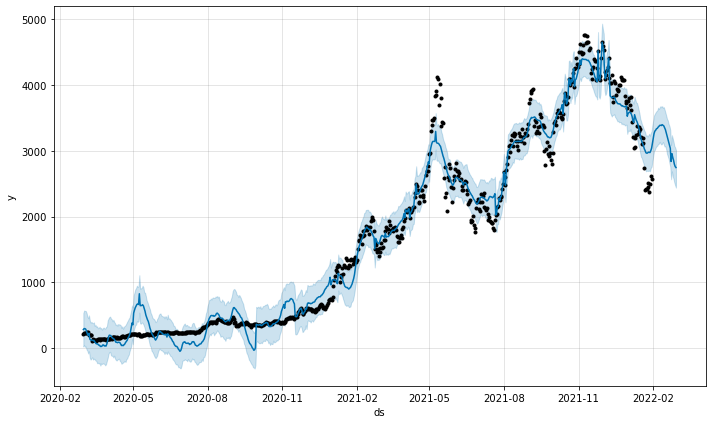

In [30]:
# Смотрим, что предсказалось
m_1.plot(forecast);

C:\Users\Nata\anaconda3\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Nata\anaconda3\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
C:\Users\Nata\anaconda3\envs\time_series\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


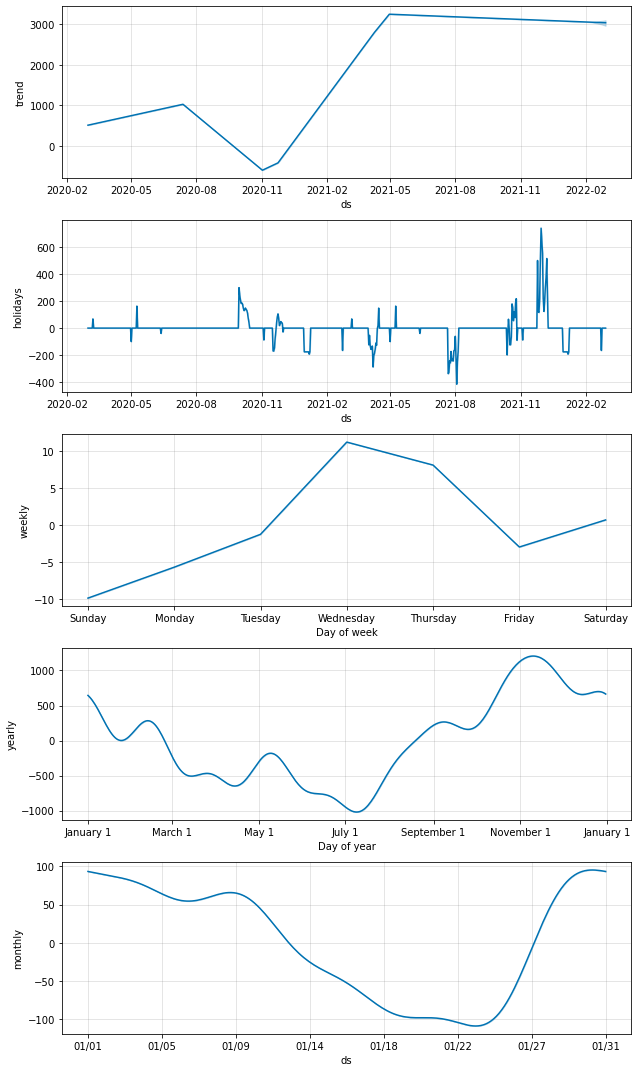

In [31]:
# Смотрим на компоненты
m_1.plot_components(forecast);

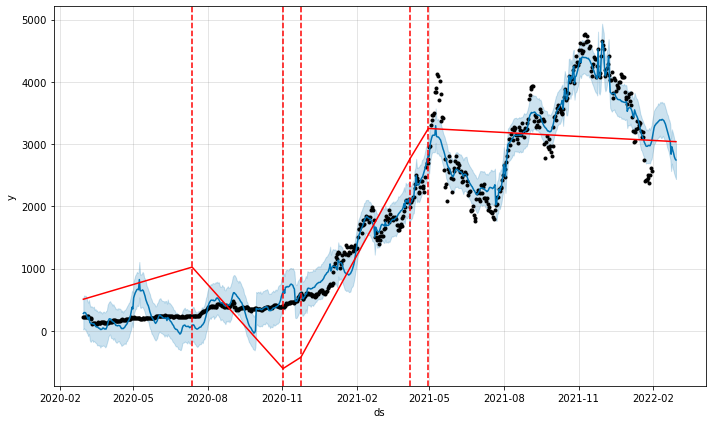

In [32]:
# визуализируем changepoints
fig = m_1.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m_1, forecast)

In [33]:
# Рисуем график с границами прогноза
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

iplot([
    go.Scatter(x=df['ds'], y=df['y'], name='fact'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='prediction'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], fill='tonexty', mode='none', name='upper'),
    go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], fill='tonexty', mode='none', name='lower'),
    go.Scatter(x=forecast['ds'], y=forecast['trend'], name='trend')
])

In [34]:
# Смотрим на фактические ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  11.938907494026902 %
MAE (средняя абсолютная ошибка) –  336.3916975756248
